In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# import some learn-to-rank method
from sharp import ShaRP
import pandas as pd
import lightgbm as lgb

# utility functions
from sharp.utils import scores_to_rank
from mlresearch.utils import set_matplotlib_style

set_matplotlib_style(42, **{"font.family":"Times"})

# data
We use the "movers" data from
Yang, Ke, Joshua R. Loftus, and Julia Stoyanovich. "Causal intersectionality for fair ranking." arXiv preprint arXiv:2006.08688 (2020).

In [2]:
file = 'https://raw.githubusercontent.com/Anon-Sci/CIFRank/master/out/ranklib_data/mv/m2/Full/fair_count__bias/R10_train_ranklib.txt'
df_train = pd.read_csv(file,delimiter=' ', names=['relevance', 'qid', 'gender', 'race', 'X', 'Y', 'meta'])

In [3]:
file = 'https://raw.githubusercontent.com/Anon-Sci/CIFRank/master/out/ranklib_data/mv/m2/Full/fair_count__bias/R10_test_ranklib.txt'
df_test = pd.read_csv(file,delimiter=' ', names=['relevance', 'qid', 'gender', 'race', 'X', 'Y', 'meta'])

In [4]:
df_test

,relevance,qid,gender,race,X,Y,meta
0,9,qid:2,1:0,2:1,3:0.1899395630036482,4:0.1937026171868585,#docid=1504;rel=9;g=M;r=B;
1,388,qid:2,1:1,2:0,3:0.5459109956735013,4:0.7920737675619858,#docid=1371;rel=388;g=F;r=W;
2,0,qid:2,1:1,2:0,3:-1.7232193585865132,4:-1.5228091763218323,#docid=1774;rel=0;g=F;r=W;
3,249,qid:2,1:0,2:0,3:0.5379536381300322,4:0.4827263530161303,#docid=1799;rel=249;g=M;r=W;
4,0,qid:2,1:0,2:1,3:-1.8589748979947567,4:-1.5740410843902115,#docid=1757;rel=0;g=M;r=B;
...,...,...,...,...,...,...,...
1995,0,qid:2,1:1,2:1,3:-1.9272819583567893,4:-1.816365924219209,#docid=1075;rel=0;g=F;r=B;
1996,0,qid:2,1:0,2:0,3:-0.7990427365806434,4:-0.6379372794003488,#docid=1753;rel=0;g=M;r=W;
1997,0,qid:2,1:1,2:0,3:-1.3948471129681417,4:-1.5304419174187094,#docid=746;rel=0;g=F;r=W;
1998,0,qid:2,1:0,2:0,3:0.2042259659259381,4:0.028230813698210594,#docid=1619;rel=0;g=M;r=W;


In [5]:
def preprocess_dataset(df):
    df['qid'] = df['qid'].str.replace('qid:', '')
    df['gender'] = df['gender'].str.replace('1:', '')
    df['race'] = df['race'].str.replace('2:', '')
    df['X'] = df['X'].str.replace('3:', '')
    df['Y'] = df['Y'].str.replace('4:', '')
    df = df.astype({'gender': int, 'race': int, 'X': float, 'Y': float})
    return df

df_train = preprocess_dataset(df_train)
df_test = preprocess_dataset(df_test)

In [6]:
df_train.dtypes

relevance      int64
qid           object
gender         int64
race           int64
X            float64
Y            float64
meta          object
dtype: object

In [7]:
# train_df = df[:1600].copy()  # first 80%
# validation_df = df[-400:].copy()  # remaining 20%

train_df = df_train.sample(frac=0.8, random_state=42)
validation_df = df_test.sample(frac=0.2, random_state=42)

# here I am taking 1st 80000 entries for train but you can use train_test_split
qids_train = train_df.groupby("qid")["qid"].count().to_numpy()
# Create ranking as the "relevance" score
X_train = train_df.sort_values('Y', ascending=False)
n_rows = X_train.shape[0]
X_train['rank'] = range(1, n_rows + 1)
# Assign outcome
y_train = X_train["rank"]
# Drop columns we don't use
X_train = X_train.drop(["Y", "relevance", "qid", "meta", "rank"], axis=1)

qids_validation = validation_df.groupby("qid")["qid"].count().to_numpy()
# Create ranking as the "relevance" score
X_validation = validation_df.sort_values('Y', ascending=False)
n_rows = X_validation.shape[0]
X_validation['rank'] = range(1, n_rows + 1)
# Assign outcome
y_validation = X_validation["rank"]
# Drop columns we don't use
X_validation = X_validation.drop(["Y", "relevance", "qid", "meta", "rank"], axis=1)


In [8]:
# # https://github.com/microsoft/LightGBM/issues/2892#issuecomment-596525112
# train_df = df[:1600]  # first 80%
# validation_df = df[400:]  # remaining 20%
# # here I am taking 1st 80000 entries for train but you can use train_test_split
# qids_train = train_df.groupby("qid")["qid"].count().to_numpy()
# X_train = train_df.drop(["qid", "Y", "relevance", "meta"], axis=1)
# y_train = train_df["relevance"].copy()
# 
# qids_validation = validation_df.groupby("qid")["qid"].count().to_numpy()
# X_validation = validation_df.drop(["qid", "Y", "relevance", "meta"], axis=1)
# y_validation = validation_df["relevance"].copy()

In [9]:
# Joao: added
y_train[y_train != 0] = scores_to_rank(y_train[y_train != 0], direction=1)
y_validation[y_validation != 0] = scores_to_rank(y_validation[y_validation != 0], direction=1)

In [10]:
model = lgb.LGBMRanker(
    objective="lambdarank",
    # metric="ndcg",
    # min_data_in_leaf=1,
    label_gain=list(range(1601)),# np.unique(y_train.values)
    verbose=-1
)
model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_validation, y_validation)],
    eval_group=[qids_validation],
    eval_at=10,
)

LGBMRanker(label_gain=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
           objective='lambdarank', verbose=-1)

In [11]:
relevance = model.predict(X_train)
relevance

array([-9.86725643, -9.86725643, -9.86725643, ...,  5.4489572 ,
        5.4489572 ,  5.4489572 ])

In [12]:
scores_to_rank(relevance, 1), y_train.values

(array([  45,   27,   30, ..., 1599, 1598, 1597]),
 array([   1,    2,    3, ..., 1598, 1599, 1600]))

# Model interpretability

In [13]:
X_train

,gender,race,X
1816,1,0,1.758635
1765,1,0,1.540274
1227,1,0,1.465894
427,1,1,1.331055
1100,1,0,1.429315
...,...,...,...
988,1,0,-3.624336
1569,1,0,-3.714049
922,1,0,-4.074175
451,1,0,-4.195559


In [ ]:
xai = ShaRP(
    qoi="ranking",
    target_function=model.predict,
    measure="shapley",
    sample_size=None,
    replace=False,
    random_state=42,
    verbose=1,
    n_jobs=31
)
xai.fit(X_train)

shapley_values = pd.DataFrame(
    xai.all(X_validation), 
    columns=X_validation.columns, 
    index=X_validation.index
)
shapley_values["score"] = model.predict(X_validation)
shapley_values["ranking"] = scores_to_rank(shapley_values["score"])
shapley_values.to_csv(f"r10_test_ranklib_{xai.qoi_.__class__.__name__.lower()}_shapley_values.csv")

  0%|          | 0/400 [00:00<?, ?it/s]

In [17]:
buckets = 10
shapley_values = pd.read_csv("r10_test_ranklib_rankingqoi_shapley_values.csv", index_col="Unnamed: 0")

shapley_values['rank_bucket'] = [
    (
        str(math.floor((rank - 1) / (shapley_values.shape[0] / buckets)) * 10) 
        + "-\n" 
        + str(math.floor(((rank - 1) / (shapley_values.shape[0] / buckets)) + 1) * 10) 
        + "%" 
    )
    if math.floor((rank - 1) / (shapley_values.shape[0] / buckets)) != 0 
    else "<10%"
    for rank in shapley_values['ranking']
]

shapley_values["Rank Bucket"] = shapley_values["rank_bucket"].str.replace("%", r"\%").str.replace("<", "$<$")
shapley_values = (
    shapley_values
    .drop(columns=["rank_bucket", "ranking", "score"])
    .melt(id_vars=["Rank Bucket"])
    .rename(columns={"variable": "Feature", "value": "Contribution"})
)

shapley_values.sort_values(["Rank Bucket", "Feature"], inplace=True)
shapley_values

,Rank Bucket,Feature,Contribution
1105,$<$10\%,X,505.331250
1122,$<$10\%,X,497.354167
1123,$<$10\%,X,640.111250
1142,$<$10\%,X,645.645833
1143,$<$10\%,X,615.743750
...,...,...,...
671,90-\n100\%,race,-74.596667
677,90-\n100\%,race,-79.627917
689,90-\n100\%,race,-79.627917
700,90-\n100\%,race,-68.129167


In [18]:
shapley_values.Feature = shapley_values.Feature.apply(lambda x: "qualification" if x=="X" else x)
shapley_values = shapley_values.groupby("Rank Bucket").apply(lambda df: df.sort_values("Feature")).reset_index(drop=True)

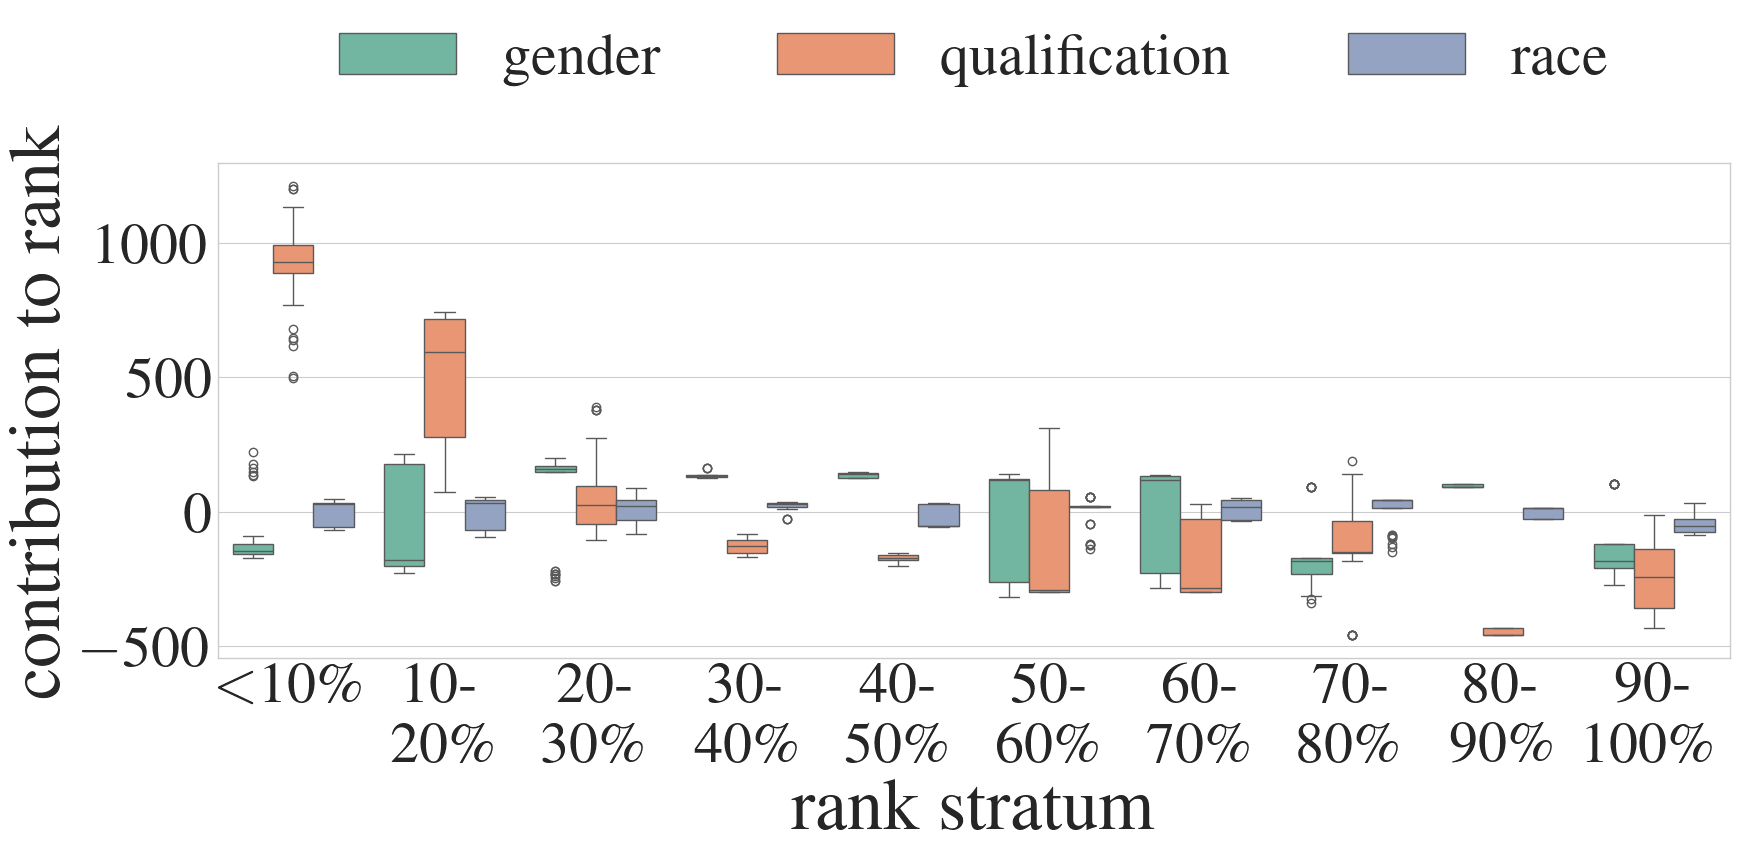

In [19]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(18, 6), sharey='row')
graph = sns.boxplot(
    x=shapley_values['Rank Bucket'], 
    y=shapley_values['Contribution'], 
    hue=shapley_values['Feature'], 
    palette="Set2"
)
graph.set_ylabel("contribution to rank")
graph.set_xlabel("rank stratum")
sns.move_legend(
    graph, "lower center", bbox_to_anchor=(.5, 1.05), ncol=4, title=None, frameon=False,
)

plt.savefig(
    f"contrs_topK.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()